In [66]:
%pip install matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Acquire Data

In [6]:
import os
import zipfile
import urllib.request
import shutil
from pathlib import Path

url = "https://content.neuralink.com/compression-challenge/data.zip"

data_dir = Path("..") / "data"
if data_dir.exists():
    shutil.rmtree(data_dir)
    data_dir.mkdir()

# download the file
with urllib.request.urlopen(url) as response, open("data.zip", 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

# extract the zip file
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("..")

# remove the zip file
os.remove("data.zip")

In [11]:
file_paths = list(data_dir.iterdir())

file_paths[:3]

[PosixPath('../data/8dd8051b-94d0-4c73-9cf4-3447cbb0755d.wav'),
 PosixPath('../data/2a661247-dfa0-42b2-9d0a-a5925ac8735a.wav'),
 PosixPath('../data/e48befb9-a32a-4bcc-af7a-2cd62d76888c.wav')]

# File Analysis

In [74]:
import wave

file_path = file_paths[0]

with wave.open(str(file_path), 'rb') as f:
    num_channels = f.getnchannels()
    sample_rate = f.getframerate()
    sample_width = f.getsampwidth()
    num_frames = f.getnframes()
    duration = num_frames / sample_rate
    compression = f.getcomptype()

    print(f"num_channels: {num_channels}")
    print(f"sample_rate: {sample_rate}")
    print(f"sample_width: {sample_width}")
    print(f"num_frames: {num_frames}")
    print(f"duration: {duration}")
    print(f"compression: {compression}")


num_channels: 1
sample_rate: 19531
sample_width: 2
num_frames: 98634
duration: 5.050125441605653
compression: NONE


Single channel (mono), ~19.5 kHz sample rate, 2-byte samples. Assuming little-endian representation.

In [75]:
import wave

file_path = file_paths[0]

with wave.open(str(file_path), 'rb') as f:
    frames = f.readframes(3)
    for xi, xj in zip(frames[::2], frames[1::2]):
        y = int.from_bytes([xi, xj], byteorder='little', signed=True)
        print(y)


-3235
-4068
-3812


In [76]:
from typing import Collection
from pathlib import Path

def get_samples(path: Path) -> "Collection[int]":
    with wave.open(str(path), 'rb') as f:
        frames = f.readframes(f.getnframes())
        return [int.from_bytes([xi, xj], 'little', signed=True) for xi, xj in zip(frames[::2], frames[1::2])]
    
samples = get_samples(file_paths[0])

print(f"length: {len(samples)}")
print(f"min: {min(samples)}")
print(f"max: {max(samples)}")

length: 98634
min: -10474
max: 12587


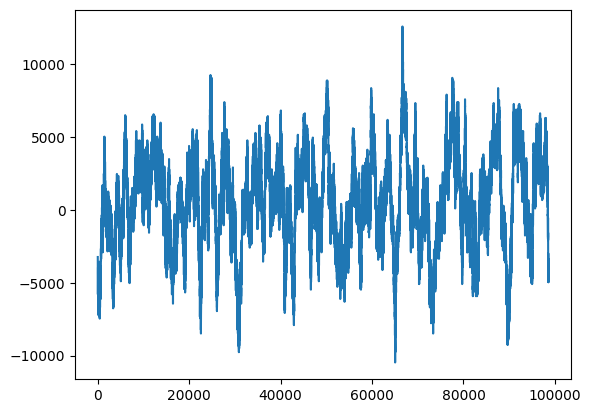

In [77]:
import matplotlib.pyplot as plt

get_samples(file_paths[0])

plt.plot(samples);

# Delta Encoding

length: 98634
min: -3235
max: 5189


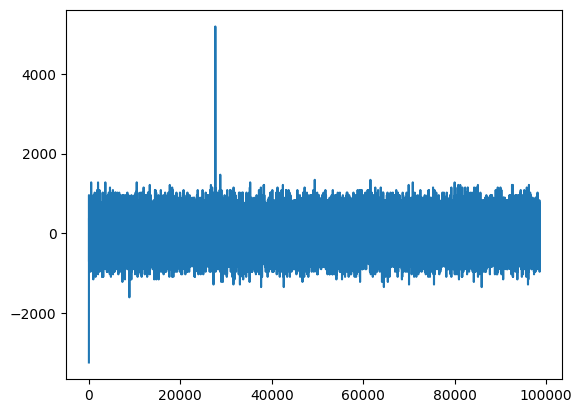

In [78]:
samples = get_samples(file_paths[0])
deltas = [samples[0]] + [samples[i] - samples[i - 1] for i in range(1, len(samples))]

print(f"length: {len(deltas)}")
print(f"min: {min(deltas)}")
print(f"max: {max(deltas)}")

plt.plot(deltas);

# Fourier Analysis

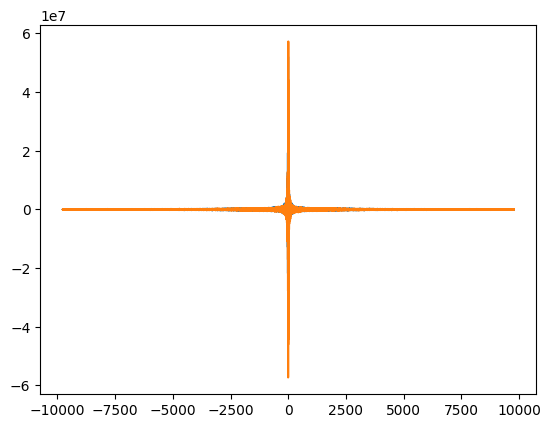

In [79]:
import numpy as np

samples = np.array(get_samples(file_paths[0]))

sp = np.fft.fft(samples)
freq = np.fft.fftfreq(len(samples), d=1/sample_rate)
plt.plot(freq, sp.real, freq, sp.imag);